# **part 1: Uploading the dataset**

In [ ]:
# Imports
import os
import json
import pandas as pd
from collections import defaultdict
from itertools import combinations
import matplotlib.pyplot as plt
from collections import Counter
import networkx as nx
import time

In [ ]:
os.environ['KAGGLE_USERNAME'] = 'xxx' #change the xxx to personal kaggle username and key to run
os.environ['KAGGLE_KEY'] = 'xxxx'

!pip install -q kaggle
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews
!unzip -q amazon-books-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
 99% 1.05G/1.06G [00:14<00:00, 97.7MB/s]
100% 1.06G/1.06G [00:15<00:00, 75.6MB/s]


In [ ]:
# check the contents of the unzipped file
!ls

amazon-books-reviews.zip  books_data.csv  Books_rating.csv  sample_data


In [ ]:
ratings_df = pd.read_csv('Books_rating.csv')
ratings_df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [ ]:
book_data_df = pd.read_csv('books_data.csv')
book_data_df.head()

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN


# **part 2: Preprocessing**

Users:
- Min: 1
- Max: 5795
- Avg: 2.42
- Median: 1.0


Text(0.5, 1.0, 'Reviews per user')

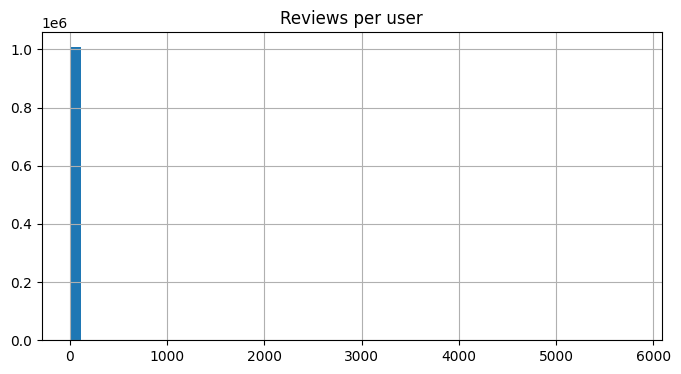

In [ ]:
#Reviews per user:
user_counts = ratings_df['User_id'].value_counts()

print("Users:")
print(f"- Min: {user_counts.min()}")
print(f"- Max: {user_counts.max()}")
print(f"- Avg: {user_counts.mean():.2f}")
print(f"- Median: {user_counts.median()}")

ax = user_counts.hist(bins=50, figsize=(8, 4))
ax.set_title("Reviews per user")


Books:
- Min: 1
- Max: 6796
- Avg: 13.51
- Median: 3.0


Text(0.5, 1.0, 'Reviews per book')

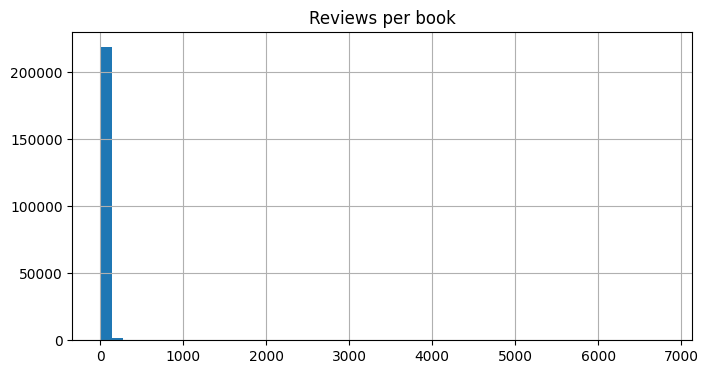

In [ ]:
#reviews per book:
book_counts = ratings_df['Id'].value_counts()

print("\nBooks:")
print(f"- Min: {book_counts.min()}")
print(f"- Max: {book_counts.max()}")
print(f"- Avg: {book_counts.mean():.2f}")
print(f"- Median: {book_counts.median()}")

ax = book_counts.hist(bins=50, figsize=(8, 4))
ax.set_title("Reviews per book")

In [ ]:
# Filter dataset
ratings_df = ratings_df[['User_id', 'Id', 'Title']] # only useful columns

min_reviews_per_user = 5
min_reviews_per_book = 10

user_counts = ratings_df['User_id'].value_counts()
active_users = user_counts[user_counts >= min_reviews_per_user].index

book_counts = ratings_df['Id'].value_counts()
popular_books = book_counts[book_counts >= min_reviews_per_book].index

ratings_df_filtered = ratings_df[ratings_df['User_id'].isin(active_users) & ratings_df['Id'].isin(popular_books)]

print(f"Filtered dataset size: {len(ratings_df_filtered)}")
ratings_df_filtered.head()

Filtered dataset size: 1011440


,User_id,Id,Title
17,A1YLDZ3VHR6QPZ,0595344550,Whispers of the Wicked Saints
66,A32ZQ5DEXBL60Z,0918973031,Dramatica for Screenwriters
106,A34M31J29P6ZN0,B000NKGYMK,Alaska Sourdough
128,A1CEJFXSJYQBTX,0789480662,Eyewitness Travel Guide to Europe
130,A2HKR9DAC138DZ,0789480662,Eyewitness Travel Guide to Europe


In [ ]:
# Check for duplicates
duplicates = ratings_df_filtered.duplicated(subset=['User_id', 'Id']).sum()
print(f"Duplicate rows: {duplicates}")

Duplicate rows: 28021


In [ ]:
# Remove duplicate rows
ratings_df_filtered = ratings_df_filtered.drop_duplicates(subset=['User_id', 'Id'])
print(f"After removing duplicates: {len(ratings_df_filtered)} rows")

After removing duplicates: 983419 rows


# **part 3: Building the graph**

In [ ]:
# Build a user_to_books dictionary
user_to_books = defaultdict(set)

for row in ratings_df_filtered.itertuples():
    user_to_books[row.User_id].add(row.Id)

In [ ]:
# Count how many users have co-reviewed each pair of books
edge_counts = defaultdict(int)

for books in user_to_books.values():
    for b1, b2 in combinations(sorted(books), 2):
        edge_counts[(b1, b2)] += 1

In [ ]:
# Build graph from pairs with two or more co-reviews
MIN_COMMON_USERS = 2
out_links = defaultdict(set)

for (b1, b2), count in edge_counts.items():
    if count >= MIN_COMMON_USERS:
        out_links[b1].add(b2)
        out_links[b2].add(b1)

in_links = defaultdict(set)

for u in out_links:
    for v in out_links[u]:
        in_links[v].add(u)

out_degree = {node: len(out_links[node]) for node in out_links}
all_nodes = set(out_links) | set(in_links)
dangling_nodes = [node for node in all_nodes if out_degree.get(node, 0) == 0]


In [ ]:
print("Graph Statistics")
num_nodes = len(all_nodes)
num_edges = sum(len(neigh) for neigh in out_links.values()) // 2 # since its baisically an undirected graph
avg_degree = sum(len(neigh) for neigh in out_links.values()) / num_nodes
max_degree = max(len(neigh) for neigh in out_links.values())
possible_edges = num_nodes * (num_nodes - 1) / 2
density = num_edges / possible_edges

print(f"Total nodes         : {num_nodes:,}")
print(f"Total edges         : {num_edges:,}")
print(f"Average degree      : {avg_degree:.2f}")
print(f"Maximum degree      : {max_degree}")
print(f"Dangling nodes      : {len(dangling_nodes)}")
print(f"Graph density       : {density:.6f}")

Graph Statistics
Total nodes         : 30,921
Total edges         : 3,773,388
Average degree      : 244.07
Maximum degree      : 6512
Dangling nodes      : 0
Graph density       : 0.007893


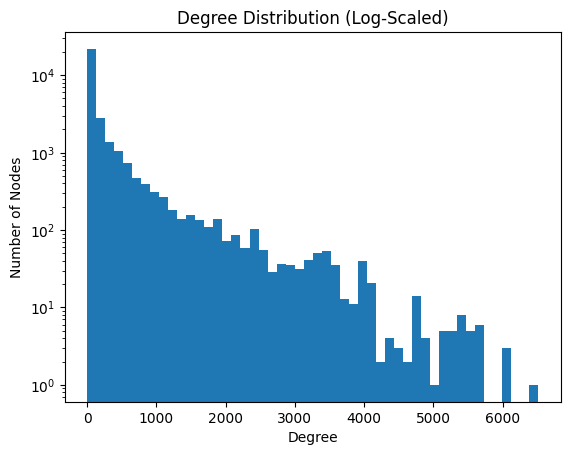

In [ ]:
# visualization
degree_values = [len(neigh) for neigh in out_links.values()]
plt.hist(degree_values, bins=50, log=True)
plt.title("Degree Distribution (Log-Scaled)")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.show()

# **part 4: PageRank**

In [ ]:
def pageRank(n, beta=0.85, epsilon=1e-6, max_iters=75):
    pr = {node: 1 / len(all_nodes) for node in all_nodes}  # Initial equal scores

    for i in range(max_iters):
        new_pr = {}
        delta = 0

        for node in all_nodes:
            rank = sum(pr[neighbor] / out_degree[neighbor] for neighbor in in_links[node])

            # Support both scalar and dict teleport
            teleport = n if isinstance(n, float) else n.get(node, 0)
            rank = beta * rank + (1 - beta) * teleport

            new_pr[node] = rank
            delta += abs(new_pr[node] - pr[node]) # Track convergence (L1 difference)

        pr = new_pr
        print(f"Iteration {i+1}, L1 change: {delta:.6f}")
        if delta < epsilon:
            print("Converged.")
            break

    return pr

In [ ]:
# Standard PageRank
total_nodes = len(all_nodes)
pr_standard = pageRank(1 / total_nodes)

Iteration 1, L1 change: 0.849998
Iteration 2, L1 change: 0.240590
Iteration 3, L1 change: 0.072706
Iteration 4, L1 change: 0.034212
Iteration 5, L1 change: 0.017656
Iteration 6, L1 change: 0.009697
Iteration 7, L1 change: 0.005682
Iteration 8, L1 change: 0.003444
Iteration 9, L1 change: 0.002191
Iteration 10, L1 change: 0.001426
Iteration 11, L1 change: 0.000962
Iteration 12, L1 change: 0.000660
Iteration 13, L1 change: 0.000465
Iteration 14, L1 change: 0.000331
Iteration 15, L1 change: 0.000241
Iteration 16, L1 change: 0.000177
Iteration 17, L1 change: 0.000132
Iteration 18, L1 change: 0.000100
Iteration 19, L1 change: 0.000076
Iteration 20, L1 change: 0.000058
Iteration 21, L1 change: 0.000045
Iteration 22, L1 change: 0.000035
Iteration 23, L1 change: 0.000028
Iteration 24, L1 change: 0.000022
Iteration 25, L1 change: 0.000018
Iteration 26, L1 change: 0.000014
Iteration 27, L1 change: 0.000011
Iteration 28, L1 change: 0.000009
Iteration 29, L1 change: 0.000008
Iteration 30, L1 change

In [ ]:
df = pd.DataFrame(pr_standard.items(), columns=['node', 'pagerank'])

# Merge using correct column names from ratings_df
df = df.merge(ratings_df[['Id', 'Title']].drop_duplicates(), how='left', left_on='node', right_on='Id')

df = df.drop(columns=['Id'])

df = df.sort_values(by='pagerank', ascending=False)
print(df[['node', 'Title', 'pagerank']].head(10))


             node                                              Title  pagerank
14371  B000IEZE3G              Harry Potter and The Sorcerer's Stone  0.000979
22050  B00097DWY0      Blink: The Power of Thinking Without Thinking  0.000704
29035  B000FC2QGE      Blink: The Power of Thinking Without Thinking  0.000704
22303  B000N6MGWQ                     Five People You Meet in Heaven  0.000681
23285  B000PCESRE                             The Catcher in the Rye  0.000671
19874  B000PMCF1A  The Catcher in the Rye [Audiobook] [Cd] [Unabr...  0.000663
1711   B000I3NFKG                             THE CATCHER IN THE RYE  0.000662
28372  B0001PIOWU                                         John Adams  0.000651
14392  B000KISQC6  Guns, Germs, and Steel: The Fates of Human Soc...  0.000623
6632   1587243938  The Tipping Point: How Little Things Can Make ...  0.000622


# **part 5: Experiments**

In [ ]:
# Degree-based ranking
degree_rank = {node: len(out_links[node]) for node in all_nodes}
top_by_degree = sorted(degree_rank.items(), key=lambda x: x[1], reverse=True)[:10]

top_by_pagerank = sorted(pr_standard.items(), key=lambda x: x[1], reverse=True)[:10]
id_to_title = dict(zip(ratings_df_filtered['Id'], ratings_df_filtered['Title']))

In [ ]:
# side by side comparisons
print(f"{'Rank':<4} {'By PageRank':<50} {'By Degree':<50}")
print("=" * 104)

for i in range(10):
    pr_id, pr_score = top_by_pagerank[i]
    deg_id, deg_score = top_by_degree[i]

    pr_title = id_to_title.get(pr_id, "Unknown Title")
    deg_title = id_to_title.get(deg_id, "Unknown Title")

    print(f"{i+1:<4} {pr_title[:48]:<50} {deg_title[:48]:<50}")

Rank By PageRank                                        By Degree                                         
1    Harry Potter and The Sorcerer's Stone              Harry Potter and The Sorcerer's Stone             
2    Blink: The Power of Thinking Without Thinking      The Catcher in the Rye                            
3    Blink: The Power of Thinking Without Thinking      The Catcher in the Rye [Audiobook] [Cd] [Unabrid  
4    Five People You Meet in Heaven                     THE CATCHER IN THE RYE                            
5    The Catcher in the Rye                             Great Gatsby (Everyman)                           
6    The Catcher in the Rye [Audiobook] [Cd] [Unabrid   The Great Gatsby                                  
7    THE CATCHER IN THE RYE                             The great Gatsby (Leading English literature lib  
8    John Adams                                         The Great Gatsby                                  
9    Guns, Germs, and Steel: The Fate

In [ ]:
# overlap statistics
pr_ids = {book_id for book_id, _ in top_by_pagerank}
deg_ids = {book_id for book_id, _ in top_by_degree}
common = pr_ids & deg_ids

print(f"\nBooks in both top-10 lists: {len(common)}")


Books in both top-10 lists: 4


# **part 6: Topic Sensitive PageRank**

Top 10 Book Categories:
categories
['Fiction']                      23419
['Religion']                      9459
['History']                       9330
['Juvenile Fiction']              6643
['Biography & Autobiography']     6324
['Business & Economics']          5625
['Computers']                     4312
['Social Science']                3834
['Juvenile Nonfiction']           3446
['Science']                       2623
Name: count, dtype: int64


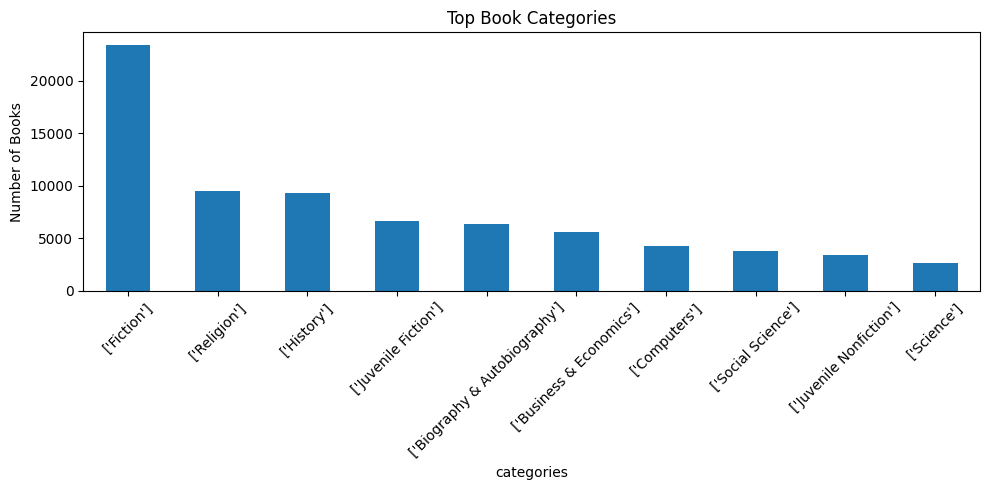

In [ ]:
# Top 10 book genres
category_counts = book_data_df['categories'].value_counts(dropna=True)

print("Top 10 Book Categories:")
print(category_counts.head(10))

category_counts.head(10).plot(kind='bar', figsize=(10, 5), title='Top Book Categories')
plt.ylabel('Number of Books')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
merged_df = ratings_df_filtered.merge(book_data_df[['Title', 'categories']], on='Title', how='left')
book_id_to_cat = dict(zip(merged_df['Id'], merged_df['categories']))

def clean_category(cat_str):
    try:
        return eval(cat_str)[0]  # Get first category from list-like string
    except:
        return None

book_id_to_cat_cleaned = {k: clean_category(v) for k, v in book_id_to_cat.items()}

In [ ]:
def make_teleport_vector(target_category):
    teleport = {
        book_id: 1 for book_id, cat in book_id_to_cat_cleaned.items() if cat == target_category
    }
    total = sum(teleport.values())
    return {k: v / total for k, v in teleport.items()}

In [ ]:
teleport_fiction = make_teleport_vector('Fiction')
pr_fiction = pageRank(teleport_fiction)

print("Top books for topic: Fiction")
top_books_fiction = sorted(pr_fiction.items(), key=lambda x: x[1], reverse=True)[:10]
for book_id, score in top_books_fiction:
    title = id_to_title.get(book_id, 'Unknown Title')
    print(f"{title} — PageRank: {score:.6f}")

Iteration 1, L1 change: 0.896835
Iteration 2, L1 change: 0.284395
Iteration 3, L1 change: 0.101155
Iteration 4, L1 change: 0.052740
Iteration 5, L1 change: 0.029630
Iteration 6, L1 change: 0.018220
Iteration 7, L1 change: 0.011990
Iteration 8, L1 change: 0.008575
Iteration 9, L1 change: 0.006529
Iteration 10, L1 change: 0.005126
Iteration 11, L1 change: 0.004092
Iteration 12, L1 change: 0.003312
Iteration 13, L1 change: 0.002711
Iteration 14, L1 change: 0.002242
Iteration 15, L1 change: 0.001869
Iteration 16, L1 change: 0.001568
Iteration 17, L1 change: 0.001322
Iteration 18, L1 change: 0.001117
Iteration 19, L1 change: 0.000946
Iteration 20, L1 change: 0.000802
Iteration 21, L1 change: 0.000681
Iteration 22, L1 change: 0.000578
Iteration 23, L1 change: 0.000490
Iteration 24, L1 change: 0.000416
Iteration 25, L1 change: 0.000354
Iteration 26, L1 change: 0.000300
Iteration 27, L1 change: 0.000255
Iteration 28, L1 change: 0.000217
Iteration 29, L1 change: 0.000184
Iteration 30, L1 change

# **part 7: Scalability & Performance**


Generating Barabási–Albert graph with 1000 nodes...
Iteration 1, L1 change: 149.850000
Iteration 2, L1 change: 127.372500
Iteration 3, L1 change: 108.266625
Iteration 4, L1 change: 92.026631
Iteration 5, L1 change: 78.222637
Iteration 6, L1 change: 66.489241
Iteration 7, L1 change: 56.515855
Iteration 8, L1 change: 48.038477
Iteration 9, L1 change: 40.832705
Iteration 10, L1 change: 34.707799
Iteration 11, L1 change: 29.501629
Iteration 12, L1 change: 25.076385
Iteration 13, L1 change: 21.314927
Iteration 14, L1 change: 18.117688
Iteration 15, L1 change: 15.400035
Iteration 16, L1 change: 13.090030
Iteration 17, L1 change: 11.126525
Iteration 18, L1 change: 9.457546
Iteration 19, L1 change: 8.038915
Iteration 20, L1 change: 6.833077
Iteration 21, L1 change: 5.808116
Iteration 22, L1 change: 4.936898
Iteration 23, L1 change: 4.196364
Iteration 24, L1 change: 3.566909
Iteration 25, L1 change: 3.031873
Iteration 26, L1 change: 2.577092
Iteration 27, L1 change: 2.190528
Iteration 28, L1 c

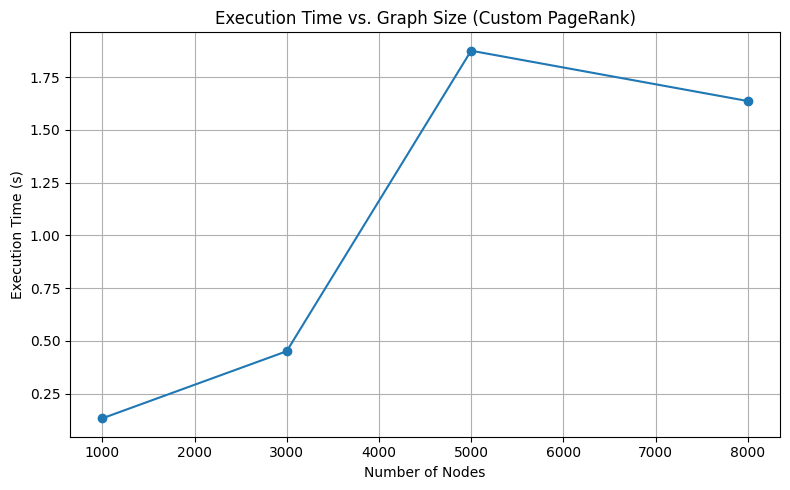

In [ ]:
# Helper to convert NetworkX graph to required format
def convert_graph_to_inputs(G_nx):
    global in_links, out_degree, all_nodes
    in_links = {}
    out_degree = {}
    all_nodes = set(G_nx.nodes())

    for node in G_nx.nodes():
        out_neighbors = list(G_nx.successors(node))
        out_degree[node] = len(out_neighbors)
        for nbr in out_neighbors:
            if nbr not in in_links:
                in_links[nbr] = []
            in_links[nbr].append(node)

    # Ensure all nodes are keys in in_links
    for node in all_nodes:
        in_links.setdefault(node, [])

# Sizes to test
node_sizes = [1000, 3000, 5000, 8000]
avg_degree = 10
times = []

for n in node_sizes:
    print(f"\nGenerating Barabási–Albert graph with {n} nodes...")
    G_nx = nx.barabasi_albert_graph(n, avg_degree // 2)
    G_nx = G_nx.to_directed()

    convert_graph_to_inputs(G_nx)
    teleport = {node: 1 for node in all_nodes}  # Uniform teleport vector

    start = time.time()
    pageRank(n=teleport)
    elapsed = time.time() - start
    times.append(elapsed)
    print(f"Execution time: {elapsed:.2f} seconds")

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(node_sizes, times, marker='o')
plt.title("Execution Time vs. Graph Size (Custom PageRank)")
plt.xlabel("Number of Nodes")
plt.ylabel("Execution Time (s)")
plt.grid(True)
plt.tight_layout()
plt.show()
